# Trying a sparse 1 layer autoencoder, then a probe

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm



from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    AutoConfig,
)
from peft import (
    get_peft_config,
    get_peft_model,
    LoraConfig,
    TaskType,
    LoftQConfig,
    IA3Config,
)
from pathlib import Path
import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")

# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl

from src.config import ExtractConfig
from src.llms.load import load_model
from src.helpers.torch_helpers import clear_mem
from src.llms.phi.model_phi import PhiForCausalLMWHS
from src.eval.ds import filter_ds_to_known
from src.datasets.act_dm import ActivationDataModule

# plt.style.use("ggplot")
# plt.style.use("seaborn-v0_8")
import seaborn as sns
sns.set_theme('paper')


## Paramsnet


In [2]:
# params

# cfg = ExtractConfig(
#     # model="microsoft/phi-2",
#     # # batch_size=1,
#     # prompt_format="phi",
# )
# cfg

# params
batch_size = 32
lr = 1e-2
wd = 0 # 1e-5

MAX_ROWS = 2000

SKIP=5 # skip initial N layers
STRIDE=4 # skip every N layers
DECIMATE=1 # discard N features for speed

device = "cuda:0"
max_epochs = 144

l1_coeff = 0.5 # 0.5  # neel uses 3e-4 ! https://github.dev/neelnanda-io/1L-Sparse-Autoencoder/blob/bcae01328a2f41d24bd4a9160828f2fc22737f75/utils.py#L106, but them they sum l1 where mean l2
    # x_feats=x_feats. other use 1e-1
# in ai saftey foundation. They use l1_coefficient=Parameter(max=0.03, min=0.008),


BASE_FOLDER = Path("/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/")
layers_names = (
    'fc1', 'Wqkv',
                 'fc2', 'out_proj')

## Load data

In [3]:
# load hidden state from a previously loaded adapter
# the columns with _base are from the base model, and adapt from adapter
# FROM TRAINING TRUTH
f1_val = next(iter(BASE_FOLDER.glob('hidden_states/.ds/ds_valtest_*')))
f1_ood = next(iter(BASE_FOLDER.glob('hidden_states/.ds/ds_OOD_*')))
f1_val, f1_ood

(PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/hidden_states/.ds/ds_valtest_8b8fd6070504d5ef'),
 PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_24/hidden_states/.ds/ds_OOD_a41d3a61513ade30'))

In [4]:
input_columns = ['binary_ans_base', 'binary_ans_adapt' ] + [f'end_residual_{layer}_base' for layer in layers_names] + [f'end_residual_{layer}_adapt' for layer in layers_names]

def ds2xy_batched(ds):
    data = []
    for layer in layers_names:
        # Stack the base and adapter representations as a 4th dim
        X1 = [ds[f'end_residual_{layer}_base'], ds[f'end_residual_{layer}_adapt']]
        X1 = rearrange(X1, 'versions b l f  -> b l f versions')[..., 0]
        data.append(X1)
    
    # concat layers
    # x = rearrange(data, 'b parts l f v -> b l (parts f) v')
    X = torch.concat(data, dim=2)[:, SKIP::STRIDE, ::DECIMATE]

    y = ds['binary_ans_base']-ds['binary_ans_adapt']
    return dict(X=X, y=y)



def prepare_ds(ds):
    """
    prepare a dataset for training

    this should front load much of the computation
    it should restrict it to the needed rows X and y
    
    """
    ds = (ds
          .with_format("torch")
          .select_columns(input_columns)
          .map(ds2xy_batched, batched=True, batch_size=128,
        remove_columns=input_columns)
    )
    return ds

def load_file_to_dm(f, stage):
    ds1 = Dataset.from_file(str(f1_val), in_memory=True).with_format("torch")
    ds1 = filter_ds_to_known(ds1, verbose=True, true_col='truth')
    ds = prepare_ds(ds1)

    # limit size
    MAX_SAMPLES = min(len(ds), MAX_ROWS*2)
    ds = ds.select(range(0, MAX_SAMPLES))

    dm = ActivationDataModule(ds, f.stem, batch_size=batch_size, num_workers=0)
    dm.setup(stage)
    dm.dm_orig = ds1
    return dm


dm = load_file_to_dm(f1_val, 'train')
dm_ood = load_file_to_dm(f1_ood, 'all')

select rows are 74.39% based on knowledge


Map:   0%|          | 0/615 [00:00<?, ? examples/s]

2024-01-12 11:57:24.541 | INFO     | src.datasets.act_dm:setup:68 - converting datasets this may take a while... ds_valtest_8b8fd6070504d5ef train
2024-01-12T11:57:24.541048+0800 INFO converting datasets this may take a while... ds_valtest_8b8fd6070504d5ef train


setup train
select rows are 74.39% based on knowledge


Map:   0%|          | 0/615 [00:00<?, ? examples/s]

2024-01-12 11:58:31.891 | INFO     | src.datasets.act_dm:setup:68 - converting datasets this may take a while... ds_OOD_a41d3a61513ade30 all
2024-01-12T11:58:31.891479+0800 INFO converting datasets this may take a while... ds_OOD_a41d3a61513ade30 all


setup all


In [5]:
dm_ood.datasets

{'all': <torch.utils.data.dataset.TensorDataset at 0x7fb4dbe73890>}

In [6]:

dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
dl_test = dm.test_dataloader()
dl_ood = dm_ood.all_dataloader()

Experiment with dataloading speeds:
- does it help to save the Xy dataset to disc, then load, while keeping in mem?. no not faster at all
- does it help to use num_workers > 0? yes 3x faster
- the shared dataset wrapper is 10x faster, and less mem

# Get importance matrix from adapter

Wqkv torch.Size([32, 7680])
out_proj torch.Size([32, 2560])
fc1 torch.Size([32, 10240])
fc2 torch.Size([32, 2560])


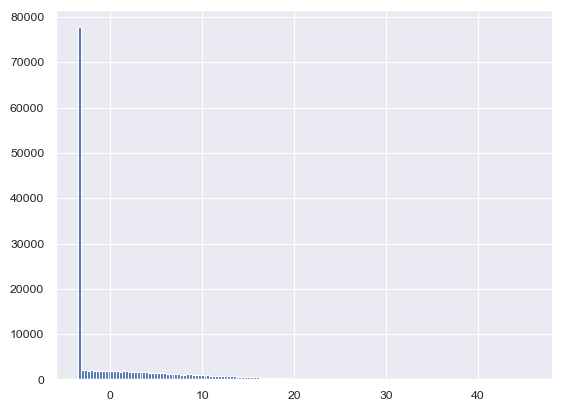

In [7]:
from src.probes.importance_matrix import get_importance_matrix


f = f"{BASE_FOLDER}/checkpoint_last/adapter_model.safetensors"
importance_matrix = get_importance_matrix(f, layers=layers_names)[SKIP::STRIDE, ::DECIMATE]
plt.hist(importance_matrix.flatten(), bins=155);

importance_matrix = None


In [8]:
# ((importance_matrix>0)*1.0).sum()

In [9]:
# ds_test2 = dm.datasets['test']
# shape1 = ds_test2[0][0].shape
# shape2= importance_matrix.shape
# np.testing.assert_equal(shape1, shape2, err_msg="shape mismatch between ds and importance matrix")


# Model

In [10]:
from sparse_autoencoder.autoencoder.model import SparseAutoencoderConfig, SparseAutoencoder

# autoencoder_input_dim = 
# expansion_factor = 2

# cfg = SparseAutoencoderConfig(
#     n_input_features=autoencoder_input_dim,
#     n_learned_features=autoencoder_input_dim * expansion_factor,
#     n_components=len(layers_names),
# )
# autoencoder = SparseAutoencoder(
#     cfg
# )

In [11]:

from src.vae.conv_inception import LinBnDrop, PLBase, recursive_requires_grad, accuracy, auroc

# from src.vae.sae import AutoEncoder, AutoEncoderConfig

In [12]:

class PLAE(PLBase):
    def __init__(
        self,
        c_in,
        steps_per_epoch,
        max_epochs,
        # depth=0,
        lr=4e-3,
        weight_decay=1e-9,
        # hs=64,
        n_latent=32,
        l1_coeff=1,
        dropout=0,
        importance_matrix=None,
        **kwargs,
    ):
        super().__init__(steps_per_epoch=steps_per_epoch, max_epochs=max_epochs, lr=lr, weight_decay=weight_decay)
        self.save_hyperparameters()
        self.importance_matrix = importance_matrix
        expansion_factor = 2

        n_layers, n_channels = c_in
        self.ae_cfg = SparseAutoencoderConfig(
            n_input_features=n_channels,
            # n_learned_features=n_channels * expansion_factor,
            n_learned_features=n_latent,
            n_components=n_layers,
        )
        self.ae = SparseAutoencoder(
            self.ae_cfg,
        )
        
        n = n_latent * n_layers
        self.head = nn.Sequential(
            LinBnDrop(n, n, bn=False),
            LinBnDrop(n, n // 4, dropout=dropout, bn=False),
            LinBnDrop(n // 4, n // 12, bn=False),
            nn.Linear(n // 12, 1),
            # nn.Tanh(),
        )
        self._ae_mode = True

    def ae_mode(self, mode=0):
        """
        mode 0, train the ae
        mode 1, train only the prob
        mode 2, train both
        """
        if mode==0:
            print('training ae')
        elif mode==1:
            print('training probe')
        elif mode==2:
            print('training both ae and probe')
        self._ae_mode = mode
        recursive_requires_grad(self.ae, mode in [0, 2])

    def forward(self, x):
        if x.ndim == 4:
            x = x.squeeze(3)
        # x = rearrange(x, "b l h -> b h l")
        # if not self._ae_mode:
        #     with torch.no_grad():
        #         l1_loss, l2_loss, loss, latent, h_rec = self.ae(x)
        # else:
        # l1_loss, l2_loss, loss, latent, h_rec = self.ae(x)

        latent, h_rec = self.ae(x)
        # l1_loss, l2_loss, loss = self.ae.losses(latent, h_rec)
        h_err = h_rec - x
        if self.importance_matrix is not None:
            importance_matrix = self.importance_matrix[None, : ].to(h_err.device)
            h_err = h_err * importance_matrix
        # for some reasin in the https://github.dev/ai-safety-foundation/sparse_autoencoder repo
        # they do sum over latent, mean over features, which is confusing because then l1_coeff will vary with different model sizes
        l2_loss = h_err.pow(2).mean(2).mean(1) # shape [batch_size n_instances features]
        l1_loss = latent.abs().sum(2).mean(1) # shape [batch_size n_instances n_latent]
        loss = (self.hparams.l1_coeff * l1_loss + l2_loss).mean(0) # scalar


        latent2 = rearrange(latent, "b l h -> b (l h)")
        pred = self.head(latent2).squeeze(1)
        return dict(
            pred=pred,
            l1_loss=l1_loss,
            l2_loss=l2_loss,
            loss=loss,
            latent=latent,
            h_rec=h_rec,
        )
    
    def on_after_backward(self):
        self.ae.post_backwards_hook()


    def _step(self, batch, batch_idx, stage="train"):
        device = next(self.parameters()).device
        x, y = batch # batch['X'], batch['y']
        x = x.to(device)
        y = y.to(device)
        x0 = x#[..., 0]
        # x1 = x[..., 1]
        info0 = self(x0)
        # info1 = self(x1)
        # ypred1 = info1["pred"]
        logits = info0["pred"]
        y_probs = F.sigmoid(logits)
        y_cls = y_probs > 0.5

        if stage == "pred":
            return (y_probs).float()
        
        pred_loss = F.binary_cross_entropy_with_logits(logits, (y>0.).float())

        # pred_loss = F.smooth_l1_loss(ypred0, y)
        rec_loss = info0["loss"] 
        l1_loss = info0["l1_loss"].mean()
        l2_loss = info0["l2_loss"].mean()

        self.log(
            f"{stage}/auroc",
            auroc(y_probs, y > 0, "binary"),
            on_epoch=True,
            on_step=False,
        )
        self.log(
            f"{stage}/acc",
            accuracy(y_cls, y > 0, "binary"),
            on_epoch=True,
            on_step=False,
        )
        self.log(
            f"{stage}/loss_pred",
            float(pred_loss),
            on_epoch=True,
            on_step=True,
            prog_bar=True,
        )
        self.log(
            f"{stage}/loss_rec",
            float(rec_loss),
            on_epoch=True,
            on_step=True,
            prog_bar=True,
        )
        self.log(f"{stage}/l1_loss", l1_loss, on_epoch=True, on_step=False)
        self.log(f"{stage}/l2_loss", l2_loss, on_epoch=True, on_step=False)
        self.log(
            f"{stage}/n",
            float(len(y)),
            on_epoch=True,
            on_step=False,
            reduce_fx=torch.sum,
        )
        if self._ae_mode == 0:
            assert torch.isfinite(rec_loss), "rec_loss is not finite"
            return rec_loss
        elif self._ae_mode == 1:
            assert torch.isfinite(pred_loss), "pred_loss is not finite"
            return pred_loss
        elif self._ae_mode == 2:
            # , train/loss_pred_epoch=0.0195, train/loss_rec_epoch=169.0
            assert torch.isfinite(pred_loss), "pred_loss is not finite"
            assert torch.isfinite(rec_loss), "rec_loss is not finite"
            return pred_loss * 50000 + rec_loss

# Train

### Metrics


### Setup

In [13]:


print(len(dl_train), len(dl_val))
b = next(iter(dl_train))
x, y = b # b['X'], b['y']
print(x.shape, "x")
if x.ndim == 3:
    x = x.unsqueeze(-1)
c_in = x.shape[1:-1]


10 5
torch.Size([32, 7, 23040]) x


In [14]:
# # TEST
# for b in tqdm(dl_train):
#     pass

In [15]:
# %%time
# # oh no, this is very slow
# g = iter(dl_train)
# b = next(g)
# b = next(g)


In [16]:

net = PLAE(
    c_in=c_in,
    steps_per_epoch=len(dl_train),
    max_epochs=max_epochs,
    lr=lr,
    weight_decay=wd,
    # hs=64,
    dropout=0,
    n_latent=512, # there will be layers * n_latent latent features
    l1_coeff=l1_coeff, 
    importance_matrix=importance_matrix,
)
print(net)


PLAE(
  (ae): SparseAutoencoder(
    (pre_encoder_bias): TiedBias(position=pre_encoder)
    (encoder): LinearEncoder(
      input_features=23040, learnt_features=512, n_components=7
      (activation_function): ReLU()
    )
    (decoder): UnitNormDecoder(learnt_features=512, decoded_features=23040, n_components=7)
    (post_decoder_bias): TiedBias(position=post_decoder)
  )
  (head): Sequential(
    (0): LinBnDrop(
      (lin): Linear(in_features=3584, out_features=3584, bias=True)
      (act): ReLU()
    )
    (1): LinBnDrop(
      (lin): Linear(in_features=3584, out_features=896, bias=True)
      (act): ReLU()
    )
    (2): LinBnDrop(
      (lin): Linear(in_features=896, out_features=298, bias=True)
      (act): ReLU()
    )
    (3): Linear(in_features=298, out_features=1, bias=True)
  )
)


In [17]:
print(c_in)
x1= x[..., 0]
with torch.no_grad():
    y = net(x1)
{k: v.abs().mean() for k, v in y.items()}, {k: v.shape for k, v in y.items()}

torch.Size([7, 23040])


({'pred': tensor(0.0533),
  'l1_loss': tensor(97.4965),
  'l2_loss': tensor(227.6037),
  'loss': tensor(276.3519),
  'latent': tensor(0.1904),
  'h_rec': tensor(0.0403)},
 {'pred': torch.Size([32]),
  'l1_loss': torch.Size([32]),
  'l2_loss': torch.Size([32]),
  'loss': torch.Size([]),
  'latent': torch.Size([32, 7, 512]),
  'h_rec': torch.Size([32, 7, 23040])})

In [18]:
from torchinfo import summary

summary(net, input_data=x1, depth=4)  # input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
PLAE                                     [32, 7, 23040]            --
├─SparseAutoencoder: 1-1                 [32, 7, 512]              --
│    └─TiedBias: 2-1                     [32, 7, 23040]            161,280
│    └─LinearEncoder: 2-2                [32, 7, 512]              82,578,944
│    │    └─ReLU: 3-1                    [32, 7, 512]              --
│    └─UnitNormDecoder: 2-3              [32, 7, 23040]            82,575,360
│    └─TiedBias: 2-4                     [32, 7, 23040]            161,280
├─Sequential: 1-2                        [32, 1]                   --
│    └─LinBnDrop: 2-5                    [32, 3584]                --
│    │    └─Linear: 3-2                  [32, 3584]                12,848,640
│    │    └─ReLU: 3-3                    [32, 3584]                --
│    └─LinBnDrop: 2-6                    [32, 896]                 --
│    │    └─Linear: 3-4                  [32, 896] 

### Train autoencoder

In [19]:
torch.set_float32_matmul_precision('medium')

In [20]:
# %%time
# for b in tqdm(dl_train):
#     pass

In [21]:
with torch.no_grad():
    o = net.predict_step(b)
    acts, h_reconstructed = net.ae(b[0])

In [22]:
# l1_coeff = 0.5

In [23]:
from src.helpers.lightning import read_metrics_csv, plot_hist, rename_pl_test_results

from lightning.pytorch.callbacks import LearningRateMonitor

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


training ae
requires_grad: True


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type              | Params
-------------------------------------------
0 | ae   | SparseAutoencoder | 165 M 
1 | head | Sequential        | 16.3 M
-------------------------------------------
181 M     Trainable params
0         Non-trainable params
181 M     Total params
726.576   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=144` reached.


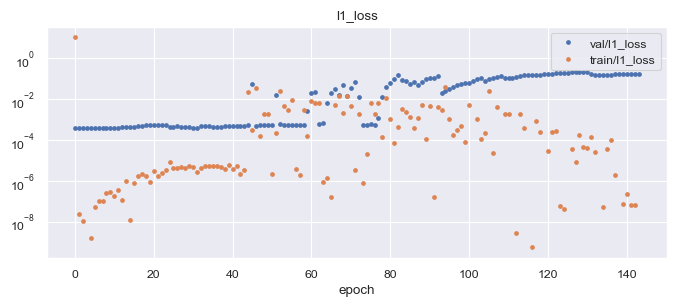

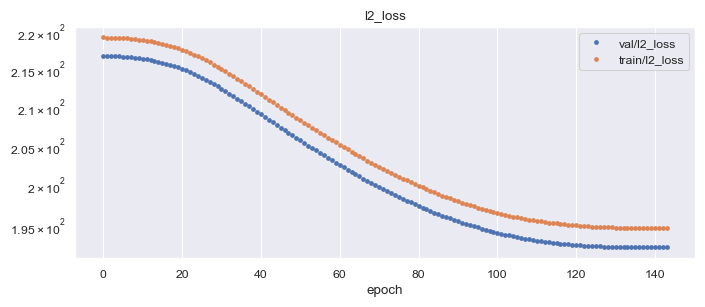

,train/loss_pred_step,train/loss_rec_step,step,val/loss_rec_step,val/loss_pred_step,val/l2_loss,val/acc,val/l1_loss,val/auroc,val/n,val/loss_pred_epoch,val/loss_rec_epoch,train/acc,train/loss_rec_epoch,train/n,train/loss_pred_epoch,train/auroc,train/l1_loss,train/l2_loss
epoch,,,,,,,,,,,,,,,,,,,
0.0,0.694568,229.834290,9,221.851349,0.686541,216.716461,0.512987,0.000388,0.486288,154.0,0.692817,216.716675,0.615635,224.270279,307.0,0.688123,0.475065,1.017092e+01,219.184860
1.0,0.694568,229.817123,19,221.834366,0.686541,216.699829,0.512987,0.000389,0.480177,154.0,0.692817,216.700012,0.615635,219.166016,307.0,0.688243,0.500000,2.429500e-08,219.166016
2.0,0.694568,229.797729,29,221.815018,0.686541,216.680847,0.512987,0.000390,0.489261,154.0,0.692817,216.681061,0.615635,219.148331,307.0,0.688243,0.500000,1.051021e-08,219.148331
3.0,0.694568,229.775055,39,221.792374,0.686541,216.658630,0.512987,0.000393,0.479834,154.0,0.692817,216.658844,0.615635,219.127945,307.0,0.688243,0.500000,0.000000e+00,219.127945
4.0,0.694568,229.748077,49,221.765396,0.686541,216.632156,0.512987,0.000395,0.486353,154.0,0.692817,216.632355,0.615635,219.103882,307.0,0.688243,0.500000,1.591786e-09,219.103882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139.0,0.694568,204.441071,1399,196.949600,0.686541,192.367126,0.512987,0.158449,0.519594,154.0,0.692790,192.446350,0.615635,194.702316,307.0,0.688243,0.500000,7.282951e-08,194.702316
140.0,0.694568,204.440079,1409,196.948700,0.686541,192.366257,0.512987,0.158640,0.519594,154.0,0.692790,192.445572,0.615635,194.701141,307.0,0.688243,0.500000,2.267677e-07,194.701141
141.0,0.694568,204.439575,1419,196.948227,0.686541,192.365799,0.512987,0.158733,0.519594,154.0,0.692790,192.445145,0.615635,194.700424,307.0,0.688243,0.504343,6.543224e-08,194.700424


In [24]:
net.ae_mode(0)
 
lr_logger = LearningRateMonitor(logging_interval='step')
trainer1 = pl.Trainer(
    # precision="16-mixed",
    # gradient_clip_val=20,
    # devices=2,
    accelerator="auto",
    devices="1",
    max_epochs=max_epochs,# * VAE_EPOCH_MULT,
    log_every_n_steps=1,
    # enable_progress_bar=False, enable_model_summary=False
    # callbacks=[lr_logger],
)

# LOAD_CHECKPONT = Path('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_52/1_ae.ckpt')
LOAD_CHECKPONT = None
if LOAD_CHECKPONT:
    PLAE.load_from_checkpoint(LOAD_CHECKPONT)
else:
    trainer1.fit(model=net, train_dataloaders=dl_train, 
                 val_dataloaders=dl_val # FIXME why does this slow it down with multiple processes?
                );

    df_hist, df_hist_step = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)
    plot_hist(df_hist, ['l2_loss', 'l1_loss', 'loss_rec'], logy=True)
    # plt.show()
    # plot_hist(df_hist_step, ['loss_rec_step'], logy=True)

    display(df_hist)


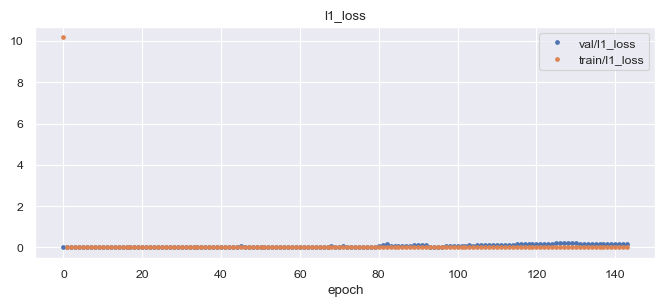

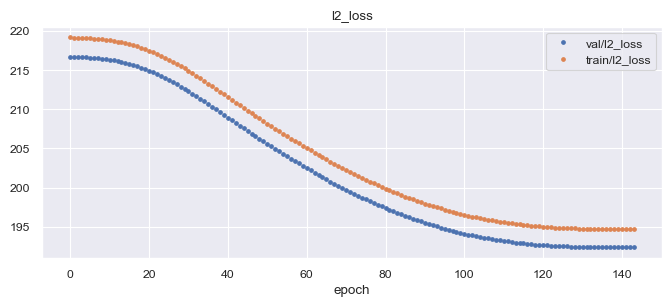

In [25]:
plot_hist(df_hist, ['l2_loss', 'l1_loss', 'loss_rec'], logy=False)

In [26]:
df_hist, df_hist_step = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)

In [27]:
# DEBUG: Check the LR
# df_hist['lr-AdamW'].plot()

In [28]:
df_hist[['train/l2_loss','train/l1_loss']]

,train/l2_loss,train/l1_loss
epoch,,
0.0,219.184860,1.017092e+01
1.0,219.166016,2.429500e-08
2.0,219.148331,1.051021e-08
3.0,219.127945,0.000000e+00
4.0,219.103882,1.591786e-09
...,...,...
139.0,194.702316,7.282951e-08
140.0,194.701141,2.267677e-07
141.0,194.700424,6.543224e-08


In [30]:
ratio = df_hist['train/l2_loss']/df_hist['train/l1_loss']
ratio = ratio[np.isfinite(ratio)]
print(f"l1 coeff should be approx {ratio.mean()/l1_coeff} but is {l1_coeff}")


# print(f"% of latent is empty {((latent>0)*1.0).mean()}")


l1 coeff should be approx 9496061906.823853 but is 0.5


In [32]:
rs3r = trainer1.test(net, dataloaders=[dl_train, dl_val, dl_test, dl_ood], verbose=False)
rs3 = rename_pl_test_results(rs3r, ["train", "val", "test", "ood"])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.6156351566314697     │    0.5129870176315308     │    0.5064935088157654     │
│        test/auroc         │            0.5            │    0.5195939540863037     │    0.5113124251365662     │
│       test/l1_loss        │            0.0            │    0.15877953171730042    │    0.1496708244085312     │
│       test/l2_loss        │     194.7000274658203     │    192.36558532714844     │    195.24403381347656     │
│   test/loss_pred_epoch    │    0.6882429718971252     │    0.6927896738052368     │    0.6931488513946533     │
│    test/loss_rec_epoch    │     194.7000274658203     │    192.44497680664062     │      195.31884765625      │
│          test/n           │           307.0           │           154.0           │           154.0           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 3        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │     0.562601625919342     │
│        test/auroc         │    0.5078710913658142     │
│       test/l1_loss        │    0.07723796367645264    │
│       test/l2_loss        │    194.25169372558594     │
│   test/loss_pred_epoch    │    0.6906099915504456     │
│    test/loss_rec_epoch    │    194.29031372070312     │
│          test/n           │           615.0           │
└───────────────────────────┴───────────────────────────┘

|                 |   train |     val |    test |     ood |
|:----------------|--------:|--------:|--------:|--------:|
| auroc           |   0.5   |   0.52  |   0.511 |   0.508 |
| acc             |   0.616 |   0.513 |   0.506 |   0.563 |
| loss_pred_epoch |   0.688 |   0.693 |   0.693 |   0.691 |
| loss_rec_epoch  | 194.7   | 192.445 | 195.319 | 194.29  |
| l1_loss         |   0     |   0.159 |   0.15  |   0.077 |
| l2_loss         | 194.7   | 192.366 | 195.244 | 194.252 |
| n               | 307     | 154     | 154     | 615     |


5/10 [00:04<00:04, 1.10it/s, v_num=295, val/loss_pred=0.0849, val/loss_rec=9.58e+5, train/loss_pred=0.350, train/loss_rec=9.8e+5]


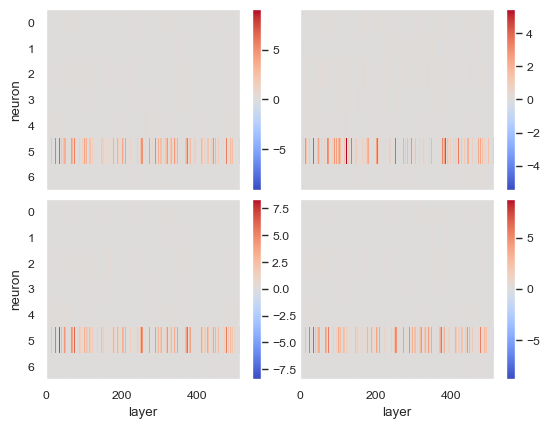

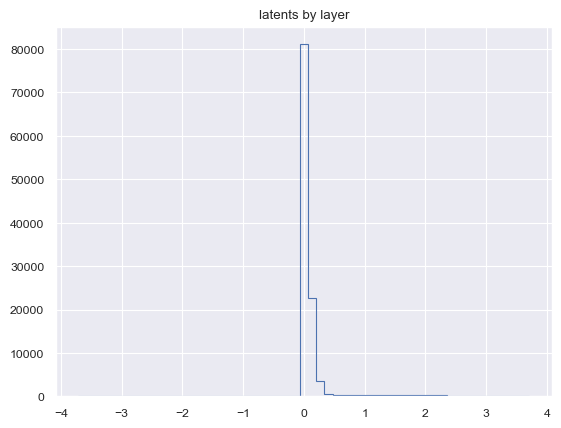

In [33]:
# visualize latent space
from matplotlib import cm


def plot_latent(latent):

    # plot image of latent space
    vmax = latent.abs().max()
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        vmax = latent[i].abs().max()
        plt.imshow(
            latent[i],
            cmap=cm.coolwarm,
            interpolation="none",
            aspect="auto",
            vmin=-vmax,
            vmax=vmax,
        )
        plt.xlabel("layer")
        plt.ylabel("neuron")
        if i < 2:
            plt.xlabel("")
            plt.xticks([])
        if i % 2 == 1:
            plt.ylabel("")
            plt.yticks([])
        plt.grid(False)
        plt.colorbar()
    # plt.colorbar()
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

    # histogram
    latentf = rearrange(latent, "b n l -> (b n) l").flatten()
    vmax = (latentf.abs().mean() + 5 * latentf.abs().std()).item()
    plt.hist(latentf, bins=55, range=[-vmax, vmax], histtype="step")
    plt.title("latents by layer")
    plt.show()


latent = y["latent"].cpu()  # .reshape(64, 24, 12) # [Batch, Latent, Layer]
plot_latent(latent)


In [34]:
latent.shape, latent.diff(dim=1).std(), latent.std(), latent.diff(dim=2).std(), 16*7

(torch.Size([32, 7, 512]), tensor(1.0963), tensor(0.7042), tensor(0.8686), 112)

# helpers

In [35]:
from src.eval.ds import ds2df

def get_acc_subset(df, query, verbose=True):
    assert (df['y'].mean()<0).any(), 'y should be [-1, 1]'
    assert (df['y'].mean()>-1).all(), 'y should be [-1, 1]'
    assert (df['y'].mean()<1).all(), 'y should be [-1, 1]'
    assert (df['probe_pred'].mean()>0).all(), 'pred should be [0,1]'
    assert (df['probe_pred'].mean()<1).all(), 'pred should be [0,1]'

    if query:
        df = df.query(query)
    # df["probe_cls"] = df["probe_pred"] > 0.5
    acc = ((df["probe_pred"]>0.5) == (df["y"]>0)).mean()
    if verbose:
        print(f"acc={acc:2.2%},\tn={len(df)},\t[{query}] ")
    return acc


def calc_metrics(dm, net, trainer=None, split="test", verbose=True):

    # predict
    dl_test = dm.create_dataloader(split)
    if trainer is None:
        trainer = pl.Trainer(logger=False, enable_progress_bar=False, enable_model_summary=False)
    rt = trainer.predict(net, dataloaders=dl_test)
    y_test_pred = np.concatenate(rt)

    # get original df
    splits = dm.splits[split]
    df = ds2df(dm.dm_orig).rename(columns=lambda s:s.replace('_base',''))
    df['y'] = dm.ds['y']
    df_test = df.iloc[splits[0] : splits[1]].copy()
    df_test["probe_pred"] = y_test_pred

    if verbose:
        print(f"probe results on subsets of the data for {split}")
    acc = get_acc_subset(df_test, "", verbose=verbose)
    get_acc_subset(
        df_test, "instructed_to_lie==True", verbose=verbose
    )  # it was ph told to lie
    get_acc_subset(
        df_test, "instructed_to_lie==False", verbose=verbose
    )  # it was told not to lie
    get_acc_subset(
        df_test, "ans==label_true", verbose=verbose
    )  # the llm gave the true ans
    get_acc_subset(
        df_test, "ans==label_instructed", verbose=verbose
    )  # the llm gave the desired ans
    acc_lie_lie = get_acc_subset(
        df_test, "instructed_to_lie==True & ans==label_instructed", verbose=verbose
    )  # it was told to lie, and it did lie
    acc_lie_truth = get_acc_subset(
        df_test, "instructed_to_lie==True & ans!=label_instructed", verbose=verbose
    )

    a = get_acc_subset(
        df_test, "instructed_to_lie==False & ans==label_instructed", verbose=False
    )
    b = get_acc_subset(
        df_test, "instructed_to_lie==False & ans!=label_instructed", verbose=False
    )
    c = get_acc_subset(
        df_test, "instructed_to_lie==True & ans==label_instructed", verbose=False
    )
    d = get_acc_subset(
        df_test, "instructed_to_lie==True & ans!=label_instructed", verbose=False
    )
    

    df_confusion = pd.DataFrame(
        [[a, b], [c, d]],
        index=["tell a truth", "tell a lie"],
        columns=["did", "didn't"],
    )
    df_confusion.index.name = "instructed to"
    df_confusion.columns.name = "llm gave"


    if verbose:
        print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe on {split}")
        print(f"⭐SECONDARY METRIC⭐ acc_lie_lie={acc_lie_lie:2.2%} from probe on {split}")
    
    print("\n\nprobe accuracy for quadrants:")
    print(df_confusion.round(2).to_markdown())
    print('\n\n')


    return dict(acc=acc, acc_lie_lie=acc_lie_lie, acc_lie_truth=acc_lie_truth, df_test=df_test, df_confusion=df_confusion)


# r = testval_metrics = calc_metrics(dm, trainer3, net, use_val=True)
# r['df_test']

### Train probe

In [36]:
# # net.save_checkpoint
# f = Path(trainer1.log_dir)/"1_ae.ckpt"
# trainer1.save_checkpoint(f)
# # PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_52/1_ae.ckpt')
# f

In [37]:
%%time
for b in tqdm(dl_train):
    pass

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 576 ms, sys: 0 ns, total: 576 ms
Wall time: 53 ms


In [38]:
%%time
for b in tqdm(dl_train):
    y = net.predict_step(b)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 7.75 s, sys: 0 ns, total: 7.75 s
Wall time: 686 ms


In [39]:

# # debug
# with torch.no_grad():
#     b = next(iter(dl_train))
#     y = net.predict_step(b)

In [40]:
net.ae_mode(1)
trainer2 = pl.Trainer(
    # precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=1,
    # enable_progress_bar=False, enable_model_summary=False
    # callbacks=[lr_logger],
)
trainer2.fit(model=net, train_dataloaders=dl_train, 
             val_dataloaders=dl_val
             );


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name | Type              | Params
-------------------------------------------
0 | ae   | SparseAutoencoder | 165 M 
1 | head | Sequential        | 16.3 M
-------------------------------------------
16.3 M    Trainable params
165 M     Non-trainable params
181 M     Total params
726.576   Total estimated model params size (MB)


training probe
requires_grad: False


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
df_hist, _ = read_metrics_csv(trainer2.logger.experiment.metrics_file_path)
plot_hist(df_hist, ['loss_pred_epoch', 'auroc'])
df_hist

In [ ]:
rs3r = trainer2.test(net, dataloaders=[dl_train, dl_val, dl_test, dl_ood])
rs3 = rename_pl_test_results(rs3r, ["train", "val", "test", "ood"])

In [ ]:
a = calc_metrics(dm, net, trainer2, 'test')
b = calc_metrics(dm, net,trainer2,  'val')
pd.DataFrame([a, b], index=['test', 'val'])

c = calc_metrics(dm_ood, net, trainer1, 'all')
pd.DataFrame([a, b, c], index=['test', 'val', 'ood'])



### Train end-to-end


In [ ]:
net.ae_mode(2)
trainer3 = pl.Trainer(
    precision="16-mixed",
    gradient_clip_val=20,
    max_epochs=max_epochs,
    log_every_n_steps=3,
    # enable_progress_bar=False, enable_model_summary=False
)
trainer3.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)
1


In [ ]:
# ds2df(dm.dm_orig)


In [ ]:
# look at hist
df_hist, _ = read_metrics_csv(trainer3.logger.experiment.metrics_file_path)
plot_hist(df_hist, ['loss_pred', 'acc'])

rs3r = trainer3.test(net, dataloaders=[dl_train, dl_val, dl_test, dl_ood], verbose=False)
rs3 = rename_pl_test_results(rs3r, ["train", "val", "test", "ood"])

# predict
a = calc_metrics(dm, net, trainer1, 'test')
b = calc_metrics(dm, net,trainer1,  'val')
pd.DataFrame([a, b], index=['test', 'val'])

c = calc_metrics(dm_ood, net, trainer1, 'all')
pd.DataFrame([a, b, c], index=['test', 'val', 'ood'])


In [ ]:
a = calc_metrics(dm, net, trainer1, 'test')
b = calc_metrics(dm, net,trainer1,  'val')
c = calc_metrics(dm_ood, net, trainer1, 'all')
df_metrics = pd.DataFrame([a, b, c], index=['test', 'val', 'ood']).iloc[:, :3]
print(df_metrics.round(3).to_markdown())
df_metrics

